# GCL Tutorial

In [69]:
%matplotlib inline #For output of the visualizations to be in the notebook
import time  #importing time  

In [70]:
import dgl #importing DGL library

def build_karate_club_graph():   #Building the standard karate club graph from GCN paper
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

In [71]:
G = build_karate_club_graph()

In [72]:
import networkx as nx
nx_G = G.to_networkx().to_undirected()

In [73]:
import torch

G.ndata['feat'] = torch.eye(34)

In [74]:
import torch.nn as nn
import torch.nn.functional as F

def gcn_message(edges):
    
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    
    def forward(self, g, inputs):
        g.ndata['h'] = inputs
        
        g.send(g.edges(), gcn_message)
        
        g.recv(g.nodes(), gcn_reduce)
        
        h = g.ndata.pop('h')
        
        return self.linear(h)

In [75]:
#Defining a 2 layer GCN model
class GCN(nn.Module):
    def __init__(self, in_features, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_features, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
net = GCN(34, 5, 2)

In [76]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])
labels = torch.tensor([0, 1])

In [77]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    
    all_logits.append(logits.detach())
    
    logp = F.log_softmax(logits, 1)
    
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    print('Epoch %d | Loss : %.4f' % (epoch, loss.item()))

/home/ronit/.conda/envs/mll/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Epoch 0 | Loss : 1.1780
Epoch 1 | Loss : 0.8733
Epoch 2 | Loss : 0.6454
Epoch 3 | Loss : 0.4972
Epoch 4 | Loss : 0.4103
Epoch 5 | Loss : 0.3594
Epoch 6 | Loss : 0.3257
Epoch 7 | Loss : 0.2983
Epoch 8 | Loss : 0.2748
Epoch 9 | Loss : 0.2518
Epoch 10 | Loss : 0.2258
Epoch 11 | Loss : 0.1981
Epoch 12 | Loss : 0.1712
Epoch 13 | Loss : 0.1445
Epoch 14 | Loss : 0.1194
Epoch 15 | Loss : 0.0974
Epoch 16 | Loss : 0.0790
Epoch 17 | Loss : 0.0644
Epoch 18 | Loss : 0.0531
Epoch 19 | Loss : 0.0444
Epoch 20 | Loss : 0.0378
Epoch 21 | Loss : 0.0325
Epoch 22 | Loss : 0.0283
Epoch 23 | Loss : 0.0248
Epoch 24 | Loss : 0.0217
Epoch 25 | Loss : 0.0190
Epoch 26 | Loss : 0.0166
Epoch 27 | Loss : 0.0145
Epoch 28 | Loss : 0.0126
Epoch 29 | Loss : 0.0109


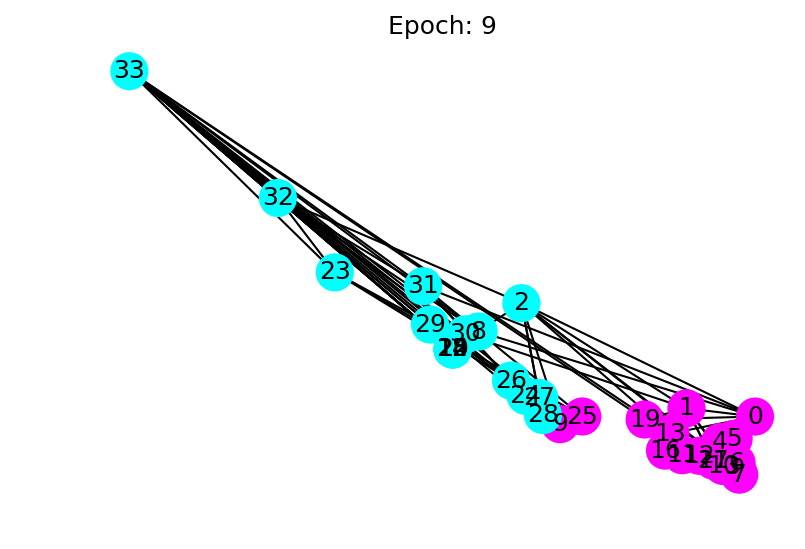

In [81]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
# draw the prediction of the first epoch
for i in range(0,10):
    draw(i)
    time.sleep(10)

In [79]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=500)

In [80]:
ani.save('basic_animation.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

/home/ronit/.conda/envs/mll/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
